In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from transformer.encoder import Encoder

In [2]:
config = {'num_heads': 12, 
          'vocab_size': 30522,
          'hidden_size': 128,
          'max_position_embeds': 512,
          'intermediate_size': 512,
          'dropout_p': 0.1,
          'input_size': (100,),
          'num_hidden_layers': 1}

## Get some toy data

The yelp sentence sentiment data set from Kaggle will do

In [3]:
rows = []
with open('yelp_labelled.txt', 'r') as FILE:
    while True:
        row = FILE.readline()
        if not row:
            break
        row = row.strip().split('\t')
        sentence = row[0]
        sentiment = int(row[1])
        rows.append({'sentence': sentence, 'sentiment': sentiment})
 
df = pd.DataFrame(rows, columns=['sentence', 'sentiment'])
df.head()

,sentence,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [4]:
df['sentiment'].value_counts()

1    500
0    500
Name: sentiment, dtype: int64

### Get our toy vocabulary

In [5]:
vocab = {'<pad>': 0, '<unk>': 1}
index = 2
for s in df['sentence'].values:
    words = s.strip().split()
    for word in words:
        i = vocab.get(word)
        if i is None:
            vocab[word] = index
            index += 1

vocab_reverse = {value: key for key, value in vocab.items()}

config['vocab_size'] = len(vocab)


### Tokenize the sentences and split into x and y 

y will be the last token of each sequence, so we can try to predict it. But mostly we just want to see if our transformer encoder trains.

In [6]:
def tokenize(sent):
    tokens = [vocab[word] for word in sent.strip().split()]
    return tokens

x = list(map(tokenize, df['sentence']))
x = tf.keras.utils.pad_sequences(x, maxlen=config['input_size'][0])
y = df['sentiment'].values

print(f'Number of sentences: {df.shape[0]}')
print(f'Vocabulary size: {config["vocab_size"]}')

Number of sentences: 1000
Vocabulary size: 2971


## Try our transformer!

We'll just train our encoder by the task of predicting the last word of each sentence

In [7]:
encoder_model = tf.keras.models.load_model('encoder_model.h5', 
                                           custom_objects={'Encoder': Encoder})

clf = Sequential([encoder_model,
                  Dense(1, activation='sigmoid')])

#clf.layers[0].trainable=False
clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 128)               640232    
                                                                 
 dense_39 (Dense)            (None, 1)                 129       
                                                                 
Total params: 640,361
Trainable params: 640,361
Non-trainable params: 0
_________________________________________________________________


In [8]:
clf.compile(optimizer=Adam(learning_rate=.001), loss='binary_crossentropy', metrics=['accuracy'])
hist = clf.fit(x, 
               y,
               epochs=10)

Epoch 1/10
32/32 [==============================] - 14s 142ms/step - loss: 0.9478 - accuracy: 0.5030
Epoch 2/10
32/32 [==============================] - 5s 142ms/step - loss: 0.6421 - accuracy: 0.6350
Epoch 3/10
32/32 [==============================] - 5s 142ms/step - loss: 0.4812 - accuracy: 0.7590
Epoch 4/10
32/32 [==============================] - 5s 142ms/step - loss: 0.2373 - accuracy: 0.9050
Epoch 5/10
32/32 [==============================] - 5s 147ms/step - loss: 0.1122 - accuracy: 0.9570
Epoch 6/10
32/32 [==============================] - 5s 141ms/step - loss: 0.0874 - accuracy: 0.9670
Epoch 7/10
32/32 [==============================] - 5s 142ms/step - loss: 0.0737 - accuracy: 0.9740
Epoch 8/10
32/32 [==============================] - 5s 141ms/step - loss: 0.0398 - accuracy: 0.9850
Epoch 9/10
32/32 [==============================] - 5s 144ms/step - loss: 0.0359 - accuracy: 0.9870
Epoch 10/10
32/32 [==============================] - 5s 150ms/step - loss: 0.0214 - accuracy: 0.991

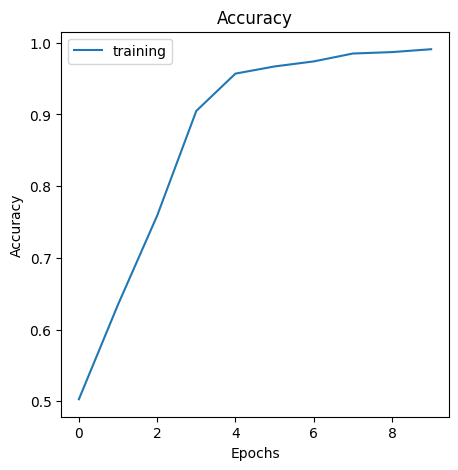

In [9]:
plt.figure(figsize=(5,5))
plt.plot(hist.history['accuracy'], label='training')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [10]:
s = ["It really tasted awful.",
     "It was very good.",
     "It was awful.",
     "This is a very bad place.",
     "The spaghetti was perfect",
     "The eggs were gross!",
     "My steak was bad."]

y = [0, 1, 0, 0, 1, 0, 0]

sentiments = ['negative', 'positive']

# Tokenize our sentence, separate last word, and pad
x = list(map(tokenize, s))
x = tf.keras.utils.pad_sequences(x, maxlen=config['input_size'][0])

# predict sentiment
y_hat = clf.predict(x)
y_hat = (y_hat >= 0.5).astype(int)
accuracy = accuracy_score(y, y_hat)
print(f'Accuracy {accuracy * 100: .2f}%\n')

for i in range(len(s)):
     # construct predicted complete sentence
     print(f'Original sentence: {s[i]} Sentiment: {sentiments[y_hat[i][0]]}')

1/1 [==============================] - 1s 1s/step
Accuracy  85.71%

Original sentence: It really tasted awful. Sentiment: negative
Original sentence: It was very good. Sentiment: positive
Original sentence: It was awful. Sentiment: negative
Original sentence: This is a very bad place. Sentiment: positive
Original sentence: The spaghetti was perfect Sentiment: positive
Original sentence: The eggs were gross! Sentiment: negative
Original sentence: My steak was bad. Sentiment: negative
